In [1]:
# colab не может найти зависимость
# !pip install -r requirements.txt

In [2]:
import os
import random
from os.path import join as pjoin
from shutil import rmtree

import albumentations as A
import numpy as np
import torch

from accelerate import Accelerator
from albumentations.pytorch.transforms import ToTensorV2

from matplotlib import pyplot as plt
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from pycocotools.coco import COCO

from helpy import (
    rename_files_in_folder,
    rename_files_and_update_annotations,
    save_coco_masks,
    save_coco_masks_npy,
    visualize_npy,
    merge_coco_json
)

from CustomCOCOSegmentation import CustomCOCOSegmentation
from train import (
    CheckpointSaver,
    IoUMetric,
    MulticlassCrossEntropyLoss,
    MulticlassDiceLoss,
    load_checkpoint,
    train
)

from TMJDataset import TMJDataset
from Unet.UNet import UNet

In [3]:
def seed_everything(seed: int = 314159, torch_deterministic: bool = False) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(torch_deterministic)


seed_everything(42, torch_deterministic=False)

In [13]:
# Определяем размер изображения
IMAGE_SIZE = 512  # Или любой другой размер

# Группировка базовых преобразований
basic_transforms = A.Compose([
    A.Resize(height=IMAGE_SIZE, width=IMAGE_SIZE, p=1.0),  # Изменение размера
    A.PadIfNeeded(min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, p=1.0),  # Добавление паддинга
    A.CropNonEmptyMaskIfExists(height=IMAGE_SIZE, width=IMAGE_SIZE),  # Обрезка
    A.HorizontalFlip(p=0.5),  # Случайный горизонтальный флип
])

# Группировка агрессивных преобразований
aggressive_transforms = A.Compose([
    A.OneOf([
        A.AdvancedBlur(p=0.5),  # Размытие
        A.GaussNoise(p=0.5),  # Шум Гаусса
        A.CLAHE(p=0.5),  # CLAHE
    ], p=0.5),  # Применяется с вероятностью 30%
    
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),  # Случайная яркость и контраст
        A.RandomGamma(p=0.5),  # Случайная гамма
        A.ColorJitter(p=0.5),  # Случайное изменение яркости, контраста и насыщенности
    ], p=0.5),  # Применяется с вероятностью 30%
    
    A.Rotate(limit=20, p=0.5),  # Случайный поворот
])

# Итоговая трансформация, где сначала применяются базовые, затем агрессивные
transforms = A.Compose([
    basic_transforms,  # Базовые преобразования
    aggressive_transforms,  # Агрессивные преобразования
    ToTensorV2(),  # Преобразование в тензор
])

In [14]:
full_dataset = TMJDataset(
    image_dir="full_dataset/images",
    mask_dir="full_dataset/masks",
    transforms=transforms
)

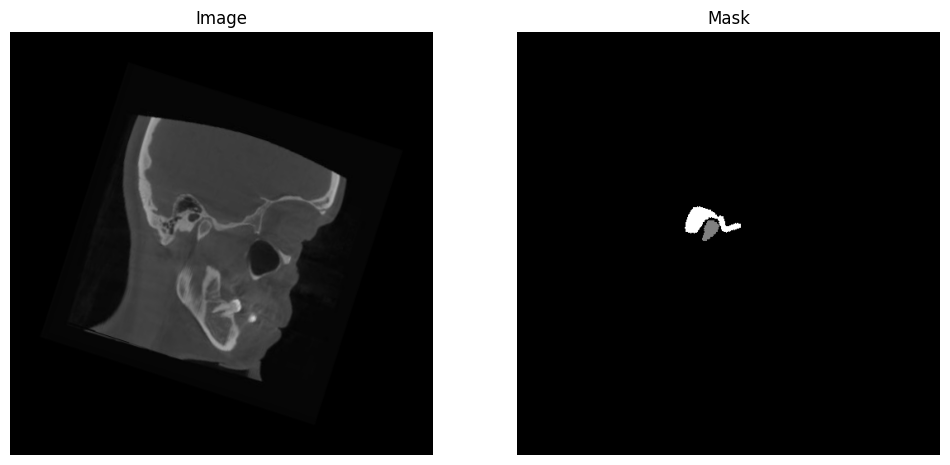

In [28]:
full_dataset.visualize(idx=2)

In [17]:
train_size = int(0.7 * len(full_dataset))
val_size = int(0.2 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

print('Количество изображений в полном датасете:',len(full_dataset))
print('Количество изображений в тренировочном датасете:',len(train_dataset))
print('Количество изображений в валидационном датасете:',len(val_dataset))
print('Количество изображений в тестовом датасете:',len(test_dataset))

Количество изображений в полном датасете: 163
Количество изображений в тренировочном датасете: 114
Количество изображений в валидационном датасете: 32
Количество изображений в тестовом датасете: 17


## Визуализируем изображение и маску

## Обучение модели

In [29]:
CLASSES_NUM = 2

LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5
BETAS = (0.9, 0.999)
BATCH_SIZE = 4
NUM_WORKERS = 4
EPOCH_NUM = 75
CHECKPOINTS_DIR = "checkpoints"
TENSORBOARD_DIR = "tensorboard"
RM_CHECKPOINTS_DIR = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [30]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)

accelerator = Accelerator(cpu=False, mixed_precision="fp16")
model = UNet(n_channels=3, n_classes=CLASSES_NUM, bilinear=False)

loss_fn = MulticlassCrossEntropyLoss(ignore_index=255, reduction="sum")
metric_fn = IoUMetric(classes_num=CLASSES_NUM, reduction="macro")

optimizer = torch.optim.AdamW(
    model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY, betas=BETAS
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer, step_size=10, gamma=0.85
)

os.makedirs(CHECKPOINTS_DIR, exist_ok=True)
checkpointer = CheckpointSaver(
    accelerator=accelerator,
    model=model,
    metric_name="mIoU",
    save_dir=CHECKPOINTS_DIR,
    rm_save_dir=RM_CHECKPOINTS_DIR,
    max_history=5,
    should_minimize=False,
)

ValueError: fp16 mixed precision requires a GPU (not 'mps').

In [31]:
os.makedirs(TENSORBOARD_DIR, exist_ok=True)
tensorboard_logger = torch.utils.tensorboard.SummaryWriter(log_dir=TENSORBOARD_DIR)

In [32]:
# акселерируем
model, optimizer, train_dataloader, val_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, val_dataloader, lr_scheduler
)

NameError: name 'accelerator' is not defined

In [ ]:
train(
    model=model,
    optimizer=optimizer,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_function=loss_fn,
    metric_function=metric_fn,
    lr_scheduler=lr_scheduler,
    accelerator=accelerator,
    epoch_num=EPOCH_NUM,
    checkpointer=checkpointer,
    tb_logger=tensorboard_logger,
    save_on_val=True,
    show_every_x_batch=15,
)